<img src="kntu-logo.png">

# Digital Image Processing
## First Computer Assignment
### Amirhosein Najafi (I)
### Student ID : 40112894
### Professor : Dr. Abrishami (II)

#### I : a.najafi@email.kntu.ac.ir
#### II : moghadam@eetd.kntu.ac.ir

## Part 1 -  Wavelet-based “edge” detection 

### Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pywt
import pywt.data
from scipy.signal import convolve2d

####  Reading  Images and Adding Noise to Image

In [4]:
def scale_images(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    return normalized_image

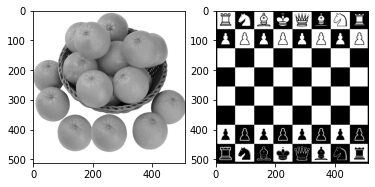

In [5]:
orange = cv2.imread(r"Oranges.jpg")
orange = cv2.cvtColor(orange, cv2.COLOR_BGR2GRAY)
orange = cv2.resize(orange, (512, 512))

chess = cv2.imread(r"Chessboard.jpg")
chess = cv2.cvtColor(chess, cv2.COLOR_BGR2GRAY)
chess = cv2.resize(chess, (512, 512))

plt.subplot(1,2,1)
plt.imshow(orange, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(chess, cmap='gray')

In [6]:
wavelet = pywt.Wavelet('haar')
dec_lo, dec_hi = np.array(wavelet.dec_lo), np.array(wavelet.dec_hi)
rec_lo, rec_hi = np.array(wavelet.rec_lo) , np.array(wavelet.rec_hi)

In [7]:
def wt2d(x2d, LoD, HiD, nlevels = 1):
    coeffs = [x2d]

    row, col = x2d.shape
    
    result = np.zeros((row, col), dtype=float)

    for l in range(nlevels):
        
        # Row Convolution and Down Sampling
        row_high = convolve2d(coeffs[-1], HiD.reshape((1, HiD.shape[0])), mode='same')[:, 1::2]
        row_low = convolve2d(coeffs[-1], LoD.reshape((1, HiD.shape[0])), mode='same')[:, 1::2]
        
        # Column Convolution and Down Sampling
        column_high_high = convolve2d(row_high, HiD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_high_low = convolve2d(row_high, LoD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_low_high = convolve2d(row_low, HiD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
        column_low_low = convolve2d(row_low, LoD.reshape((LoD.shape[0],1)), mode='same')[1::2, :]
          
        coeffs[-1] = scale_images(column_high_high)
        coeffs.append(scale_images(column_high_low))
        coeffs.append(scale_images(column_low_high))
        coeffs.append(scale_images(column_low_low))
                
        row = int(row / 2)
        
        result[0:row , 0:row] = scale_images(column_low_low)
        result[row:2 * row , 0:row] = column_low_high
        result[0:row , row: 2 * row] = column_high_low
        result[row:2 * row , row:2 * row] = column_high_high
                
    return coeffs, result

In [8]:
def upsample(image,ax):
    num_rows, num_cols = image.shape
    if ax == "row":
        output_array = np.zeros((2 * num_rows, num_cols))
        output_array[::2, :] = image
    else:
        output_array = np.zeros((num_rows, 2 * num_cols))
        output_array[:, ::2] = image
    return output_array


In [9]:
def iwt2d(y2d, LoD, HiD, nlevels = 1):
    
    row, col = y2d.shape
    row = int(row / (2 ** nlevels))
    
    output_array_r = np.zeros((2 * row, col))
    output_array_c = np.zeros((row, 2 * col))
    
    current_coeffs = [None, None, None, None]
    
    for l in range(nlevels):
        
        # Get Current Coeffs
        current_coeffs[0] = y2d[0:row , 0:row]
        current_coeffs[1] = y2d[0:row , row: 2 * row]
        current_coeffs[2] = y2d[row:2 * row , 0:row]
        current_coeffs[3] = y2d[row:2 * row , row:2 * row]
        
        # Up Sampleing

        current_coeffs[0] = upsample(current_coeffs[0],"row")
        current_coeffs[1] = upsample(current_coeffs[1],"row")
        current_coeffs[2] = upsample(current_coeffs[2],"row")
        current_coeffs[3] = upsample(current_coeffs[3],"row")
                
        # Convoloution Columns
        column_high_high = convolve2d(current_coeffs[3], HiD.reshape((LoD.shape[0],1)), mode='same')
        column_high_low = convolve2d(current_coeffs[1], LoD.reshape((LoD.shape[0],1)), mode='same')
        column_low_high = convolve2d(current_coeffs[2], HiD.reshape((LoD.shape[0],1)), mode='same')
        column_low_low = convolve2d(current_coeffs[0], LoD.reshape((LoD.shape[0],1)), mode='same')
        
        # Summation
        row_high = column_high_high + column_high_low
        row_low = column_low_high + column_low_low
        
        # Up Sampleing
        row_high = upsample(row_high,"col")
        row_low = upsample(row_low,"col")
        
        # Convoloution Rows
        row_high = convolve2d(row_high, HiD.reshape((1,LoD.shape[0])), mode='same')
        row_low = convolve2d(row_low, LoD.reshape((1,LoD.shape[0])), mode='same')

        row = row * 2
        
        y2d[0:row, 0:row] = row_high + row_low
        
    return(y2d)
        
        
        

In [10]:
nlevel = 1
DWTOrange1, DecImgOrange1 = wt2d(orange, dec_lo, dec_hi, nlevel)
DWTChess1, DecImgChess1 = wt2d(chess, dec_lo, dec_hi, nlevel)


nlevel = 2
DWTOrange2, DecImgOrange2 = wt2d(orange, dec_lo, dec_hi, nlevel)
DWTChess2, DecImgChess2 = wt2d(chess, dec_lo, dec_hi, nlevel)

nlevel = 3
DWTOrange3, DecImgOrange3 = wt2d(orange, dec_lo, dec_hi, nlevel)
DWTChess3, DecImgChess3 = wt2d(chess, dec_lo, dec_hi, nlevel)

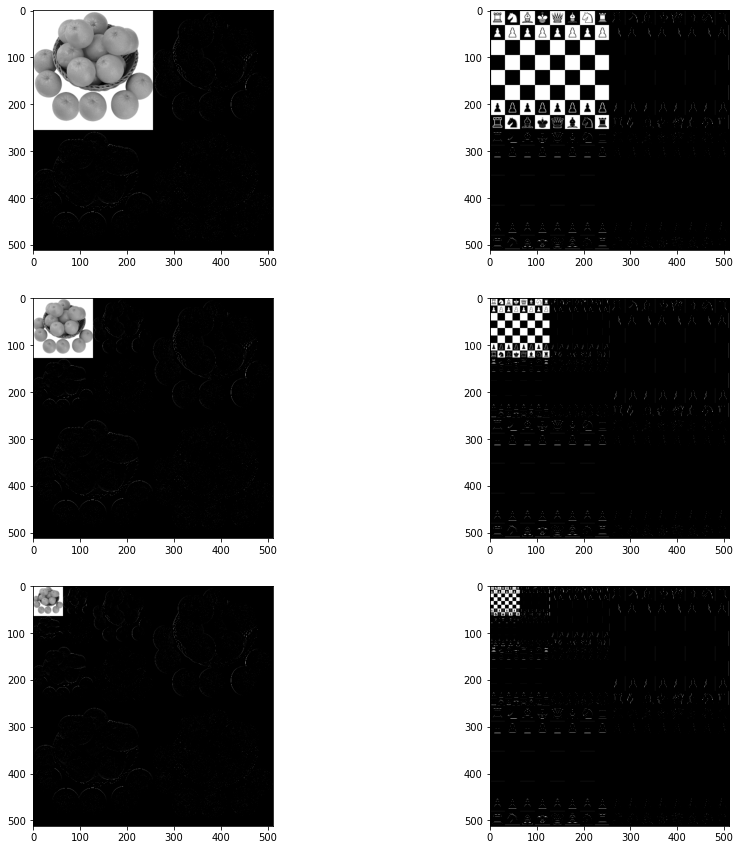

In [11]:
plt.figure(figsize=(15, 15))  # Set the desired width and height


plt.subplot(3,2,1)
plt.imshow(DecImgOrange1, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,2)
plt.imshow(DecImgChess1, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,3)
plt.imshow(DecImgOrange2, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,4)
plt.imshow(DecImgChess2, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,5)
plt.imshow(DecImgOrange3, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,6)
plt.imshow(DecImgChess3, cmap='gray', vmin=0, vmax=255)

In [12]:
def make_LL_zero(img, level):
    row , col = img.shape
    r = int(row / (2 ** level))
    img[0 :r, 0:r] = 0
    return img

In [13]:
DecImgOrange1_No_LL = make_LL_zero(DecImgOrange1.copy(), 1)
DecImgChess1_No_LL = make_LL_zero(DecImgChess1.copy(), 1)

DecImgOrange2_No_LL = make_LL_zero(DecImgOrange2.copy(), 2)
DecImgChess2_No_LL = make_LL_zero(DecImgChess2.copy(), 2)

DecImgOrange3_No_LL = make_LL_zero(DecImgOrange3.copy(), 3)
DecImgChess3_No_LL = make_LL_zero(DecImgChess3.copy(), 3)

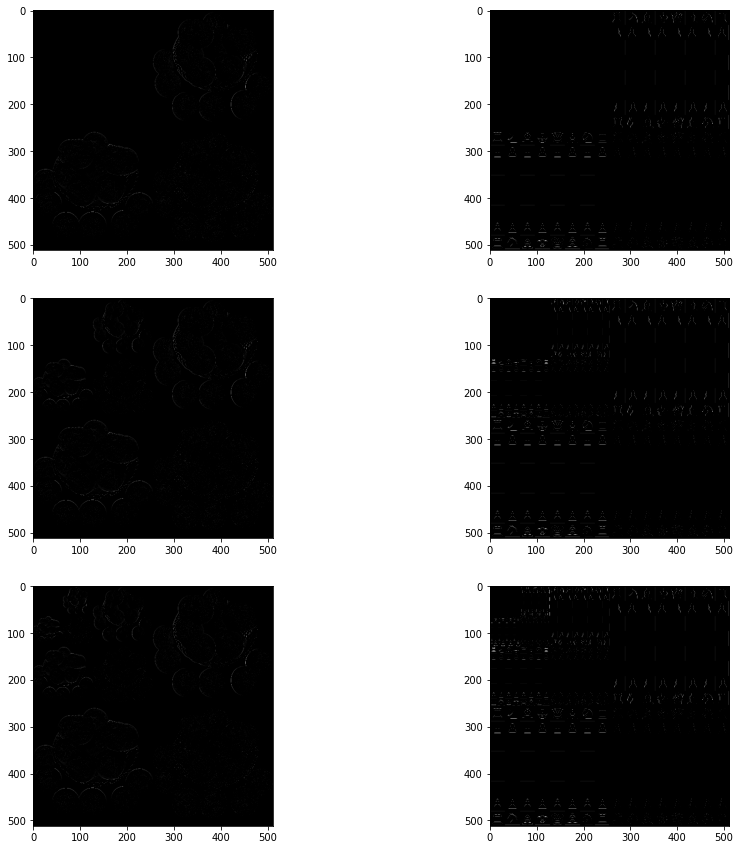

In [14]:
plt.figure(figsize=(15, 15))  # Set the desired width and height


plt.subplot(3,2,1)
plt.imshow(DecImgOrange1_No_LL, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,2)
plt.imshow(DecImgChess1_No_LL, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,3)
plt.imshow(DecImgOrange2_No_LL, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,4)
plt.imshow(DecImgChess2_No_LL, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,5)
plt.imshow(DecImgOrange3_No_LL, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,6)
plt.imshow(DecImgChess3_No_LL, cmap='gray', vmin=0, vmax=255)

In [15]:
nlevel = 1
RecImgOrange1 = iwt2d(DecImgOrange1_No_LL.copy(), rec_lo, dec_hi, nlevel)
RecImgChess1 = iwt2d(DecImgChess1_No_LL.copy(), rec_lo, dec_hi, nlevel)

nlevel = 2
RecImgOrange2 = iwt2d(DecImgOrange2_No_LL.copy(), rec_lo, dec_hi, nlevel)
RecImgChess2 = iwt2d(DecImgChess2_No_LL.copy(), rec_lo, dec_hi, nlevel)

nlevel = 3
RecImgOrange3 = iwt2d(DecImgOrange3_No_LL.copy(), rec_lo, dec_hi, nlevel)
RecImgChess3 = iwt2d(DecImgChess3_No_LL.copy(), rec_lo, dec_hi, nlevel)

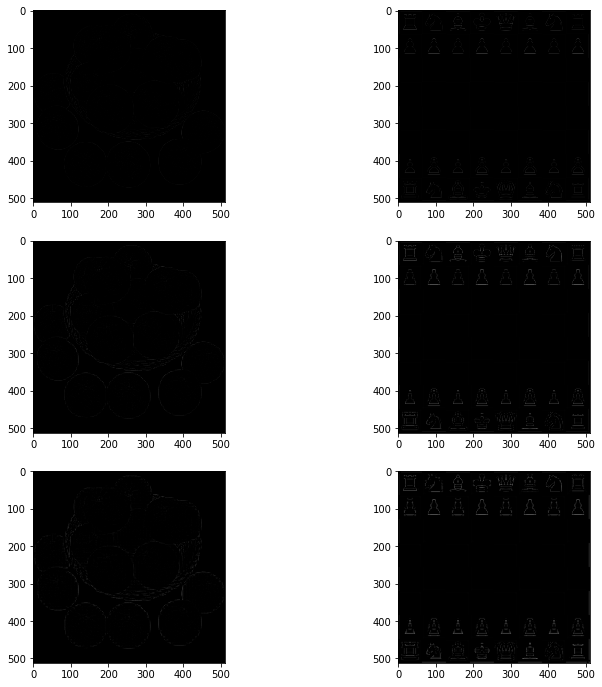

In [16]:
plt.figure(figsize=(12, 12))  # Set the desired width and height


plt.subplot(3,2,1)
plt.imshow(RecImgOrange1, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,2)
plt.imshow(RecImgChess1, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,3)
plt.imshow(RecImgOrange2, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,4)
plt.imshow(RecImgChess2, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,5)
plt.imshow(RecImgOrange3, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,6)
plt.imshow(RecImgChess3, cmap='gray', vmin=0, vmax=255)

In [17]:
def make_LL_HH_zero(img, level):
    row , col = img.shape
    r = int(row / (2 ** level))
    img[0 :r, 0:r] = 0
    
    img[r :r * 2, r:r * 2] = 0
    return img

In [18]:
DecImgOrange1_No_LL_HH = make_LL_HH_zero(DecImgOrange1.copy(), 1)
DecImgChess1_No_LL_HH = make_LL_HH_zero(DecImgChess1.copy(), 1)

DecImgOrange2_No_LL_HH = make_LL_HH_zero(DecImgOrange2.copy(), 2)
DecImgChess2_No_LL_HH = make_LL_HH_zero(DecImgChess2.copy(), 2)

DecImgOrange3_No_LL_HH = make_LL_HH_zero(DecImgOrange3.copy(), 3)
DecImgChess3_No_LL_HH = make_LL_HH_zero(DecImgChess3.copy(), 3)

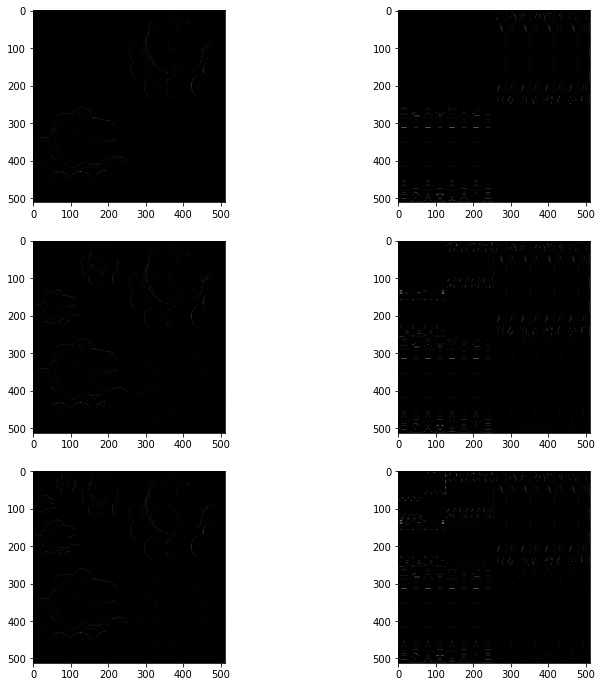

In [19]:
plt.figure(figsize=(12, 12))  # Set the desired width and height


plt.subplot(3,2,1)
plt.imshow(DecImgOrange1_No_LL_HH, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,2)
plt.imshow(DecImgChess1_No_LL_HH, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,3)
plt.imshow(DecImgOrange2_No_LL_HH, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,4)
plt.imshow(DecImgChess2_No_LL_HH, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,5)
plt.imshow(DecImgOrange3_No_LL_HH, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,6)
plt.imshow(DecImgChess3_No_LL_HH, cmap='gray', vmin=0, vmax=255)

In [20]:
nlevel = 1
RecImgOrange1 = iwt2d(DecImgOrange1_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)
RecImgChess1 = iwt2d(DecImgChess1_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)

nlevel = 2
RecImgOrange2 = iwt2d(DecImgOrange2_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)
RecImgChess2 = iwt2d(DecImgChess2_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)

nlevel = 3
RecImgOrange3 = iwt2d(DecImgOrange3_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)
RecImgChess3 = iwt2d(DecImgChess3_No_LL_HH.copy(), rec_lo, rec_hi, nlevel)

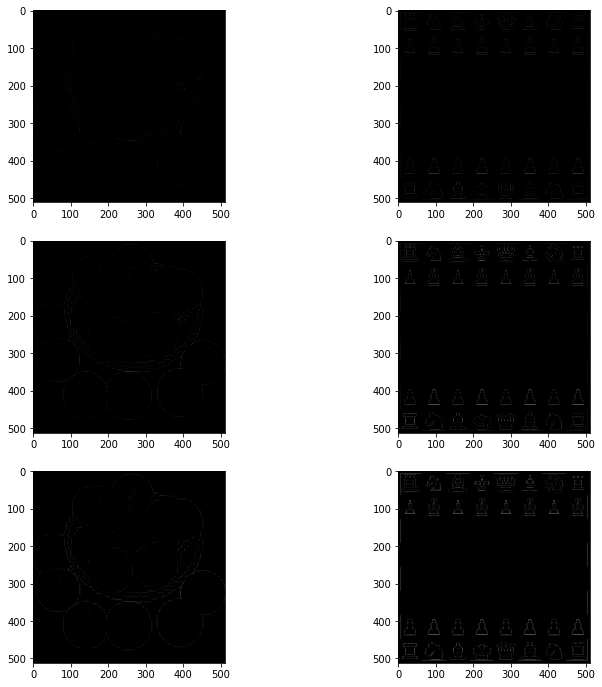

In [21]:
plt.figure(figsize=(12, 12))  # Set the desired width and height


plt.subplot(3,2,1)
plt.imshow(RecImgOrange1, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,2)
plt.imshow(RecImgChess1, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,3)
plt.imshow(RecImgOrange2, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,4)
plt.imshow(RecImgChess2, cmap='gray', vmin=0, vmax=255)

plt.subplot(3,2,5)
plt.imshow(RecImgOrange3, cmap='gray', vmin=0, vmax=255)
plt.subplot(3,2,6)
plt.imshow(RecImgChess3, cmap='gray', vmin=0, vmax=255)

####  d ) When we remove the approximation part of the Discrete Wavelet Transform (DWT), we are essentially isolating the high-frequency components of the image. After reconstruction, we can observe only the high-frequency portion, which predominantly represents the edges of the image.



#### e) In the chessboard, we observe frequent color changes between squares. As depicted in the reconstructed image, the edges are visible. Additionally, the corners of the squares become more apparent due to the pronounced color variations in those areas. When we increase the decomposition level of the DWF (Discrete Wavelet Transform), the edges become thicker.